# 복잡한 object 구별하기 (강이지 vs 고양이) : from Deep learning with Python 

## 아래 코드는 "케라스 창시자에게 배우는 딥러닝"의  역자 Github (https://github.com/rickiepark/deep-learning-with-python-notebooks) 에서 받은 소스파일을 교육목적으로 재구성함

In [1]:
import keras
keras.__version__

import os, shutil # 파일 연산을 위한 라이브러리 

## 파이썬 기능을 사용하여, 파일 분류 

In [2]:
# 원본 데이터셋을 압축 해제한 디렉터리 경로
original_dataset_dir = 'data/cats_and_dogs/train'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = 'data/cats_and_dogs_small'
if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
    shutil.rmtree(base_dir)   
os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [3]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))

print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))

print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

훈련용 고양이 이미지 전체 개수: 1000
훈련용 강아지 이미지 전체 개수: 1000
검증용 고양이 이미지 전체 개수: 500
검증용 강아지 이미지 전체 개수: 500
테스트용 고양이 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


## 데이터 전처리 

데이터는 네트워크에 주입되기 전에 부동 소수 타입의 텐서로 적절하게 전처리되어 있어야 합니다. 지금은 데이터가 JPEG 파일로 되어 있으므로 네트워크에 주입하려면 대략 다음 과정을 따릅니다.

1.	사진 파일을 읽습니다.
2.	JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.
3.	그다음 부동 소수 타입의 텐서로 변환합니다.
4.	픽셀 값(0에서 255 사이)의 스케일을 [0, 1] 사이로 조정합니다(신경망은 작은 입력 값을 선호합니다).

좀 복잡하게 보일 수 있지만 다행히 케라스는 이런 단계를 자동으로 처리하는 유틸리티를 가지고 있습니다. 케라스는 `keras.preprocessing.image`에 이미지 처리를 위한 헬퍼 도구들을 가지고 있습니다. 특히 `ImageDataGenerator` 클래스는 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꾸어주는 파이썬 제너레이터를 만들어 줍니다. 이 클래스를 사용해 보겠습니다.

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다 (강아지 vs 고양이)
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


In [6]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [8]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [9]:
# history= model.fit(train_images,train_labels,epochs=20, batch_size=100, verbose=2,validation_data=(test_images, test_labels))

history = model.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)


Epoch 1/30
100/100 - 6s - loss: 0.7074 - accuracy: 0.4925 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/30
100/100 - 6s - loss: 0.6916 - accuracy: 0.5275 - val_loss: 0.6795 - val_accuracy: 0.5840
Epoch 3/30
100/100 - 6s - loss: 0.6918 - accuracy: 0.5205 - val_loss: 0.7053 - val_accuracy: 0.4990
Epoch 4/30
100/100 - 6s - loss: 0.6834 - accuracy: 0.5320 - val_loss: 0.6803 - val_accuracy: 0.5110
Epoch 5/30
100/100 - 6s - loss: 0.6610 - accuracy: 0.6170 - val_loss: 0.6430 - val_accuracy: 0.6350
Epoch 6/30
100/100 - 6s - loss: 0.6149 - accuracy: 0.6620 - val_loss: 0.6453 - val_accuracy: 0.6430
Epoch 7/30
100/100 - 6s - loss: 0.5734 - accuracy: 0.7005 - val_loss: 0.6024 - val_accuracy: 0.6840
Epoch 8/30
100/100 - 6s - loss: 0.5085 - accuracy: 0.7450 - val_loss: 0.5541 - val_accuracy: 0.7340
Epoch 9/30
100/100 - 6s - loss: 0.4592 - accuracy: 0.7760 - val_loss: 0.6318 - val_accuracy: 0.7000
Epoch 10/30
100/100 - 6s - loss: 0.3831 - accuracy: 0.8305 - val_loss: 0.6151 - val_accuracy: 0.7180

In [10]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

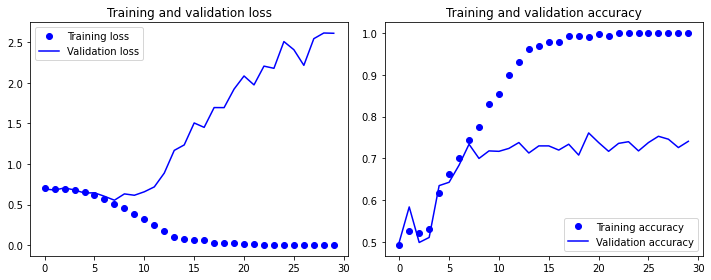

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Overfitting : 데이터 augmentation (증식) 으로 학습 데이터 증식시키기

과대적합은 학습할 샘플이 너무 적어 새로운 데이터에 일반화할 수 있는 모델을 훈련시킬 수 없기 때문에 발생합니다. 무한히 많은 데이터가 주어지면 데이터 분포의 모든 가능한 측면을 모델이 학습할 수 있을 것입니다. 데이터 증식은 기존의 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법입니다. 이 방법은 그럴듯한 이미지를 생성하도록 여러 가지 랜덤한 변환을 적용하여 샘플을 늘립니다. 훈련 시에 모델이 정확히 같은 데이터를 두 번 만나지 않도록 하는 것이 목표입니다. 모델이 데이터의 여러 측면을 학습하면 일반화에 도움이 될 것입니다.

케라스에서는 `ImageDataGenerator`가 읽은 이미지에 여러 종류의 랜덤 변환을 적용하도록 설정할 수 있습니다. 예제를 먼저 만들어 보죠:

In [12]:
datagen = ImageDataGenerator(
    rotation_range=40, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

추가적인 매개변수가 몇 개 더 있습니다(케라스 문서를 참고하세요). 이 코드를 간단히 살펴보죠.

* `rotation_range`는 랜덤하게 사진을 회전시킬 각도 범위입니다(0-180 사이).
* `width_shift_range`와 `height_shift_range`는 사진을 수평과 수직으로 랜덤하게 평행 이동시킬 범위입니다(전체 넓이와 높이에 대한 비율).
* `shear_range`는 랜덤하게 전단 변환을 적용할 각도 범위입니다.
* `zoom_range`는 랜덤하게 사진을 확대할 범위입니다.
* `horizontal_flip`은 랜덤하게 이미지를 수평으로 뒤집습니다. 수평 대칭을 가정할 수 있을 때 사용합니다(예를 들어, 풍경/인물 사진).
* `fill_mode`는 회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략입니다.


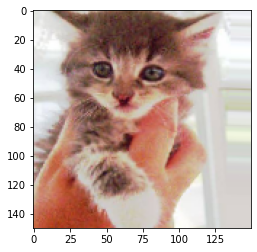

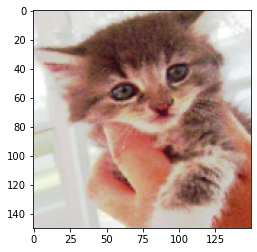

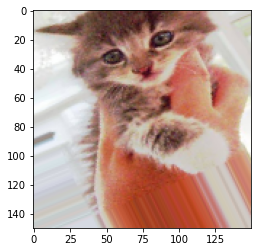

In [26]:
# 이미지 전처리 유틸리티 모듈
from keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

# 증식할 이미지 선택합니다
img_path = fnames[3]

# 이미지를 읽고 크기를 변경합니다
img = image.load_img(img_path, target_size=(150, 150))

# (150, 150, 3) 크기의 넘파이 배열로 변환합니다
x = image.img_to_array(img)

# (1, 150, 150, 3) 크기로 변환합니다
x = x.reshape((1,) + x.shape)

# flow() 메서드는 랜덤하게 변환된 이미지의 배치를 생성합니다.
# 무한 반복되기 때문에 어느 지점에서 중지해야 합니다!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break

plt.show()

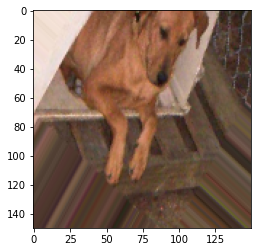

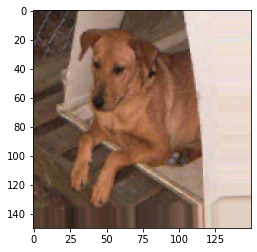

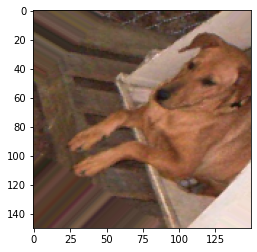

In [27]:
# 이미지 전처리 유틸리티 모듈
from keras.preprocessing import image

fnames = sorted([os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)])

# 증식할 이미지 선택합니다
img_path = fnames[3]

# 이미지를 읽고 크기를 변경합니다
img = image.load_img(img_path, target_size=(150, 150))

# (150, 150, 3) 크기의 넘파이 배열로 변환합니다
x = image.img_to_array(img)

# (1, 150, 150, 3) 크기로 변환합니다
x = x.reshape((1,) + x.shape)

# flow() 메서드는 랜덤하게 변환된 이미지의 배치를 생성합니다.
# 무한 반복되기 때문에 어느 지점에서 중지해야 합니다!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break

plt.show()

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=32,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블을 만들어야 합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 - 20s - loss: 0.6948 - accuracy: 0.5166 - val_loss: 0.6885 - val_accuracy: 0.5489
Epoch 2/100
100/100 - 20s - loss: 0.6795 - accuracy: 0.5546 - val_loss: 0.6655 - val_accuracy: 0.6224
Epoch 3/100
100/100 - 20s - loss: 0.6495 - accuracy: 0.6171 - val_loss: 0.6303 - val_accuracy: 0.6269
Epoch 4/100
100/100 - 20s - loss: 0.6227 - accuracy: 0.6465 - val_loss: 0.6038 - val_accuracy: 0.6798
Epoch 5/100
100/100 - 20s - loss: 0.6307 - accuracy: 0.6313 - val_loss: 0.6139 - val_accuracy: 0.6567
Epoch 6/100
100/100 - 20s - loss: 0.5936 - accuracy: 0.6910 - val_loss: 0.5738 - val_accuracy: 0.6888
Epoch 7/100
100/100 - 20s - loss: 0.5895 - accuracy: 0.6853 - val_loss: 0.6406 - val_accuracy: 0.5896
Epoch 8/100
100/100 - 20s - loss: 0.6100 - accuracy: 0.6624 - val_loss: 0.5503 - val_accuracy: 0.7113
Epoch 9/100
100/100 - 20s - loss: 0.5483 - accuracy: 0.7213 - val_loss: 0.5299 - val_accuracy: 0.733

Epoch 80/100
100/100 - 20s - loss: 0.1924 - accuracy: 0.9278 - val_loss: 0.3878 - val_accuracy: 0.8744
Epoch 81/100
100/100 - 20s - loss: 0.1590 - accuracy: 0.9366 - val_loss: 0.4000 - val_accuracy: 0.8724
Epoch 82/100
100/100 - 20s - loss: 0.1645 - accuracy: 0.9343 - val_loss: 0.4223 - val_accuracy: 0.8687
Epoch 83/100
100/100 - 20s - loss: 0.1482 - accuracy: 0.9435 - val_loss: 0.4414 - val_accuracy: 0.8576
Epoch 84/100
100/100 - 21s - loss: 0.1515 - accuracy: 0.9366 - val_loss: 0.4640 - val_accuracy: 0.8464
Epoch 85/100
100/100 - 20s - loss: 0.1436 - accuracy: 0.9460 - val_loss: 0.5462 - val_accuracy: 0.8634
Epoch 86/100
100/100 - 20s - loss: 0.1412 - accuracy: 0.9407 - val_loss: 0.4549 - val_accuracy: 0.8615
Epoch 87/100
100/100 - 20s - loss: 0.1710 - accuracy: 0.9287 - val_loss: 0.3860 - val_accuracy: 0.8572
Epoch 88/100
100/100 - 20s - loss: 0.1518 - accuracy: 0.9422 - val_loss: 0.5165 - val_accuracy: 0.8402
Epoch 89/100
100/100 - 20s - loss: 0.1486 - accuracy: 0.9422 - val_loss: 

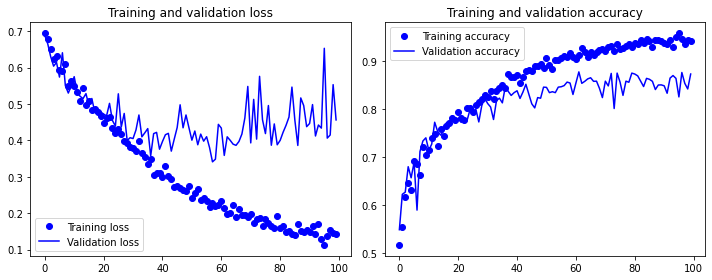

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 - 21s - loss: 0.6978 - accuracy: 0.5229 - val_loss: 0.6802 - val_accuracy: 0.5114
Epoch 2/100
100/100 - 20s - loss: 0.6833 - accuracy: 0.5407 - val_loss: 0.6922 - val_accuracy: 0.5122
Epoch 3/100
100/100 - 20s - loss: 0.6927 - accuracy: 0.5138 - val_loss: 0.6915 - val_accuracy: 0.5711
Epoch 4/100
100/100 - 20s - loss: 0.6928 - accuracy: 0.5196 - val_loss: 0.6925 - val_accuracy: 0.5090
Epoch 5/100
100/100 - 20s - loss: 0.6910 - accuracy: 0.5289 - val_loss: 0.6751 - val_accuracy: 0.5527
Epoch 6/100
100/100 - 20s - loss: 0.6885 - accuracy: 0.5268 - val_loss: 0.6846 - val_accuracy: 0.5799
Epoch 7/100
100/100 - 21s - loss: 0.6902 - accuracy: 0.5492 - val_loss: 0.6845 - val_accuracy: 0.5335
Epoch 8/100
100/100 - 21s - loss: 0.6848 - accuracy: 0.5455 - val_loss: 0.6820 - val_accuracy: 0.5596
Epoch 9/100
100/100 - 20s - loss: 0.6824 - accuracy: 0.5584 - val_loss: 0.6812 - val_accuracy: 0.563

Epoch 80/100
100/100 - 20s - loss: 0.2795 - accuracy: 0.8816 - val_loss: 0.3873 - val_accuracy: 0.8544
Epoch 81/100
100/100 - 20s - loss: 0.2698 - accuracy: 0.8832 - val_loss: 0.4016 - val_accuracy: 0.8492
Epoch 82/100
100/100 - 20s - loss: 0.2729 - accuracy: 0.8791 - val_loss: 0.4095 - val_accuracy: 0.8344
Epoch 83/100
100/100 - 20s - loss: 0.2770 - accuracy: 0.8803 - val_loss: 0.3673 - val_accuracy: 0.8389
Epoch 84/100
100/100 - 20s - loss: 0.2577 - accuracy: 0.8889 - val_loss: 0.4278 - val_accuracy: 0.8484
Epoch 85/100
100/100 - 20s - loss: 0.2355 - accuracy: 0.9023 - val_loss: 0.4943 - val_accuracy: 0.8286
Epoch 86/100
100/100 - 20s - loss: 0.2382 - accuracy: 0.9012 - val_loss: 0.4297 - val_accuracy: 0.8447
Epoch 87/100
100/100 - 20s - loss: 0.2494 - accuracy: 0.8980 - val_loss: 0.5001 - val_accuracy: 0.8496
Epoch 88/100
100/100 - 20s - loss: 0.2639 - accuracy: 0.8876 - val_loss: 0.4420 - val_accuracy: 0.8550
Epoch 89/100
100/100 - 20s - loss: 0.2546 - accuracy: 0.8939 - val_loss: 

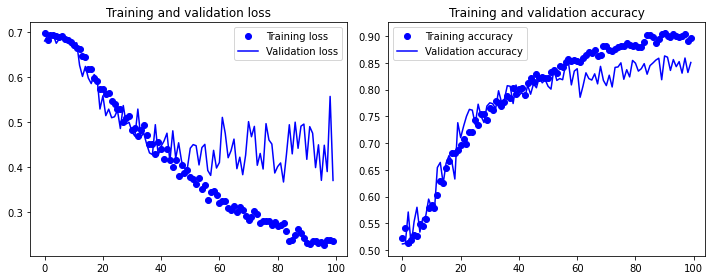

In [50]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=32,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블을 만들어야 합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2
)

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 컨브넷의 학습 시각화하기

딥러닝 모델을 '블랙 박스' 같다고 자주 이야기합니다. 학습된 표현에서 사람이 이해하기 쉬운 형태를 뽑아내거나 제시하기 어렵기 때문입니다. 일부 딥러닝 모델에서는 이 말이 어느정도 맞지만 컨브넷에서는 전혀 아닙니다. 컨브넷의 표현은 시각적인 개념을 학습한 것이기 때문에 시각화하기 아주 좋습니다. 2013년부터 이런 표현들을 시각화하고 해석하는 다양한 기법들이 개발되었습니다. 여기서 모두를 다룰 수는 없지만 가장 사용이 편하고 유용한 세 가지 기법을 다루겠습니다.

* 컨브넷 중간 층의 출력(중간 층에 있는 활성화)을 시각화하기 : 연속된 컨브넷층이 입력을 어떻게 변형시키는지 이해하고 개별적인 컨브넷 필터의 의미를 파악하는 데 도움이 됩니다.
* 컨브넷 필터를 시각화하기 : 컨브넷의 필터가 찾으려는 시각적인 패턴과 개념이 무엇인지 상세하게 이해하는 데 도움이 됩니다.
* 클래스 활성화에 대한 히트맵을 이미지에 시각화하기 : 이미지의 어느 부분이 주어진 클래스에 속하는 데 기여했는지 이해하고 이미지에서 객체의 위치를 추정하는 데 도움이 됩니다.

In [52]:
img_path = 'data/cats_and_dogs_small/test/cats/cat.1700.jpg'

# 이미지를 4D 텐서로 변경합니다
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# 모델이 훈련될 때 입력에 적용한 전처리 방식을 동일하게 사용합니다
img_tensor /= 255.

# 이미지 텐서의 크기는 (1, 150, 150, 3)입니다
print(img_tensor.shape)

(1, 150, 150, 3)


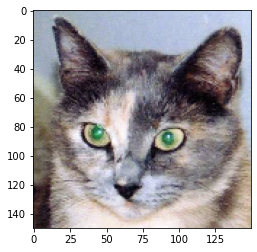

In [53]:
plt.imshow(img_tensor[0])
plt.show()

In [54]:
from keras import models

# 상위 8개 층의 출력을 추출합니다:
layer_outputs = [layer.output for layer in model.layers[:8]]
# 입력에 대해 8개 층의 출력을 반환하는 모델을 만듭니다:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [55]:
# 층의 활성화마다 하나씩 8개의 넘파이 배열로 이루어진 리스트를 반환합니다:
activations = activation_model.predict(img_tensor)

In [56]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


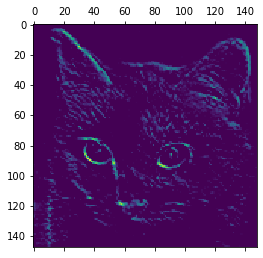

In [57]:
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')
plt.show()

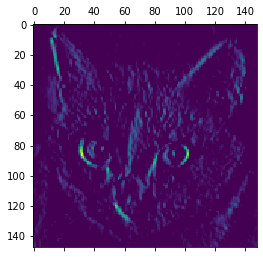

In [58]:
plt.matshow(first_layer_activation[0, :, :, 20], cmap='viridis')
plt.show()

/home/parc/anaconda3/envs/keras/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


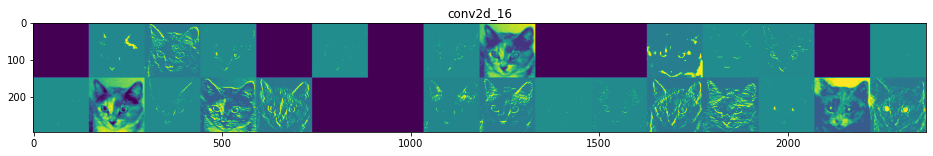

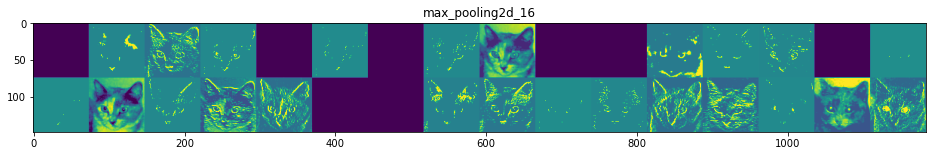

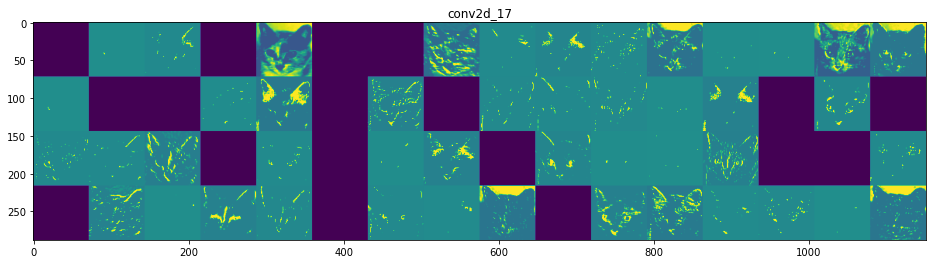

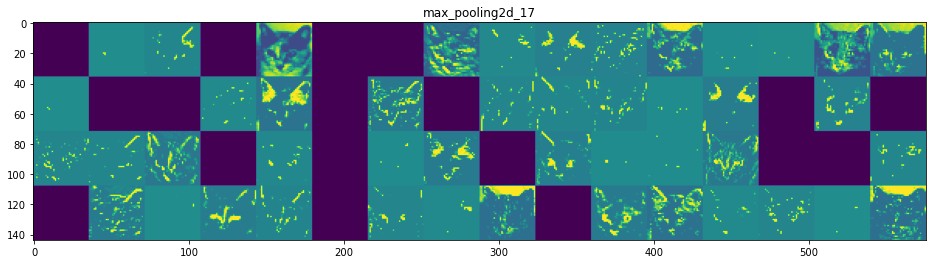

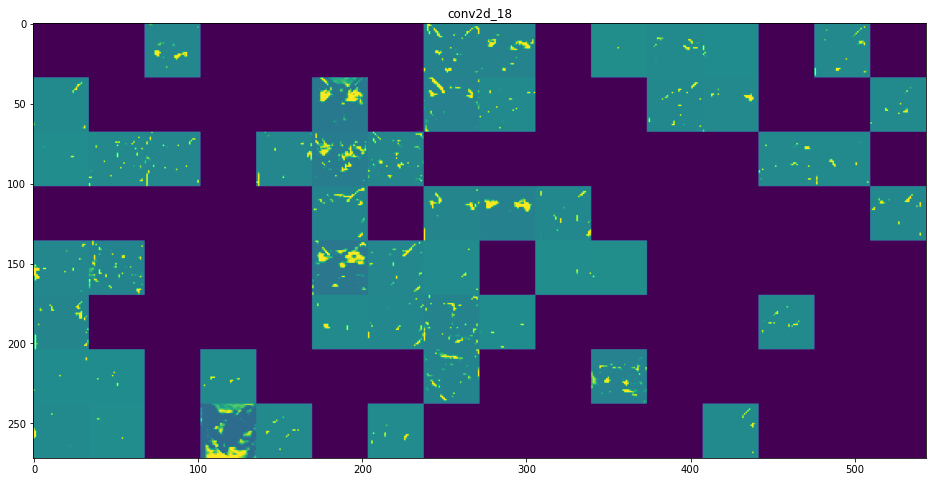

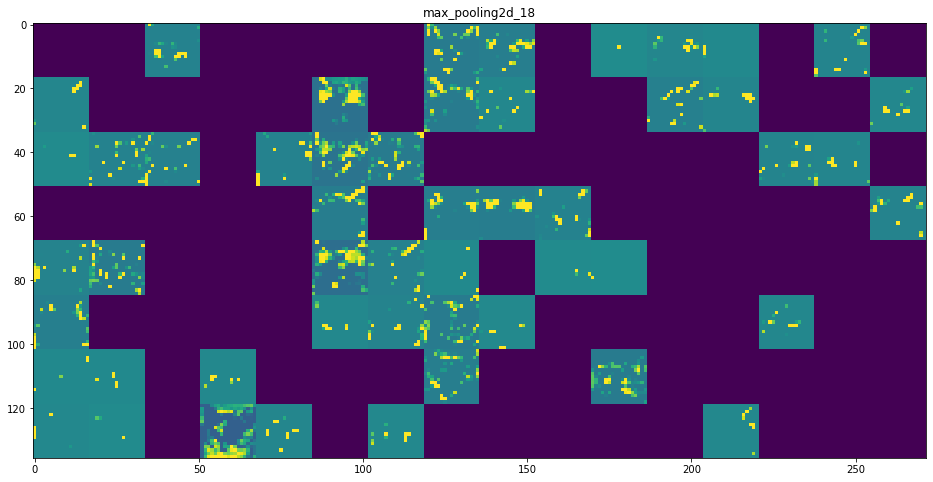

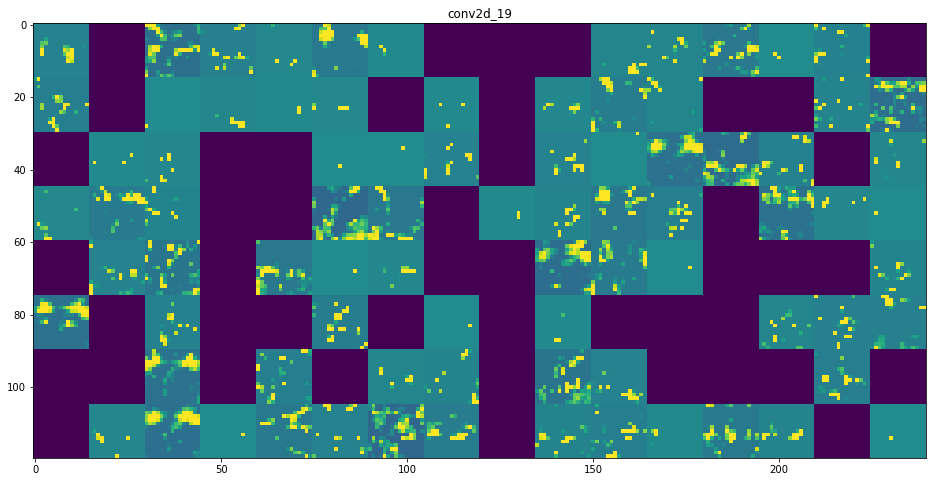

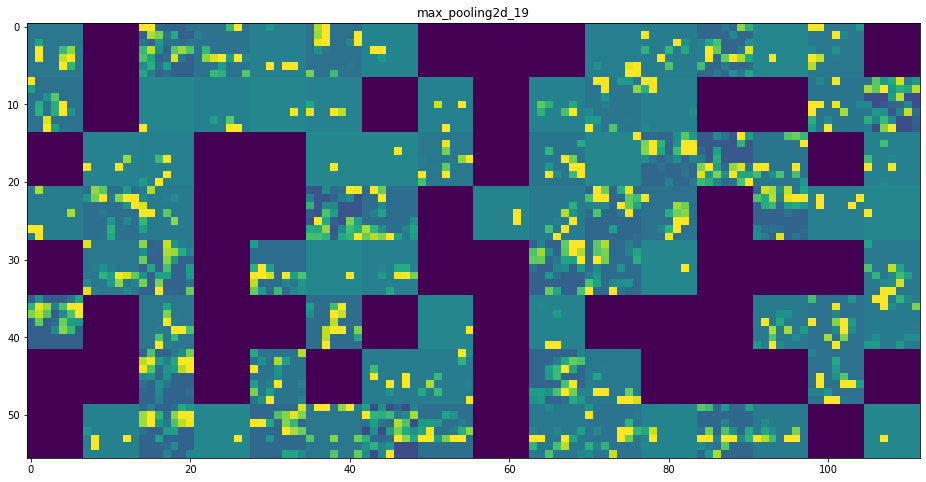

In [59]:
# 층의 이름을 그래프 제목으로 사용합니다
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

## ResNet 

In [65]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add


# number of classes
K = 1 # On and OFF
 
 
input_tensor = Input(shape=(150, 150, 3), dtype='float32', name='input')


def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
    
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(1, activation='sigmoid')(x)
 
resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 156, 156, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 75, 75, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 75, 75, 64)   256         conv2d_73[0][0]                  
____________________________________________________________________________________________

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 - 21s - loss: 0.9315 - accuracy: 0.5669 - val_loss: 0.7024 - val_accuracy: 0.4962
Epoch 2/100
100/100 - 21s - loss: 0.6631 - accuracy: 0.6357 - val_loss: 0.8553 - val_accuracy: 0.5032
Epoch 3/100
100/100 - 21s - loss: 0.6546 - accuracy: 0.6482 - val_loss: 0.7377 - val_accuracy: 0.5057
Epoch 4/100
100/100 - 21s - loss: 0.6292 - accuracy: 0.6610 - val_loss: 0.6499 - val_accuracy: 0.5973
Epoch 5/100
100/100 - 21s - loss: 0.6203 - accuracy: 0.6749 - val_loss: 1.0906 - val_accuracy: 0.5184
Epoch 6/100
100/100 - 21s - loss: 0.6108 - accuracy: 0.6761 - val_loss: 0.8123 - val_accuracy: 0.5335
Epoch 7/100
100/100 - 20s - loss: 0.6247 - accuracy: 0.6705 - val_loss: 0.9409 - val_accuracy: 0.5329
Epoch 8/100
100/100 - 21s - loss: 0.6232 - accuracy: 0.6602 - val_loss: 0.9258 - val_accuracy: 0.5996
Epoch 9/100
100/100 - 21s - loss: 0.5963 - accuracy: 0.6859 - val_loss: 0.8753 - val_accuracy: 0.547

Epoch 80/100
100/100 - 21s - loss: 0.1911 - accuracy: 0.9246 - val_loss: 0.5448 - val_accuracy: 0.8183
Epoch 81/100
100/100 - 21s - loss: 0.1791 - accuracy: 0.9271 - val_loss: 0.3522 - val_accuracy: 0.8460
Epoch 82/100
100/100 - 21s - loss: 0.1870 - accuracy: 0.9249 - val_loss: 0.8671 - val_accuracy: 0.7716
Epoch 83/100
100/100 - 21s - loss: 0.1806 - accuracy: 0.9253 - val_loss: 0.4318 - val_accuracy: 0.8402
Epoch 84/100
100/100 - 21s - loss: 0.1704 - accuracy: 0.9337 - val_loss: 0.5043 - val_accuracy: 0.8084
Epoch 85/100
100/100 - 21s - loss: 0.2061 - accuracy: 0.9161 - val_loss: 0.6156 - val_accuracy: 0.8260
Epoch 86/100
100/100 - 21s - loss: 0.1674 - accuracy: 0.9283 - val_loss: 0.3827 - val_accuracy: 0.8615
Epoch 87/100
100/100 - 21s - loss: 0.1596 - accuracy: 0.9359 - val_loss: 0.4715 - val_accuracy: 0.8547
Epoch 88/100
100/100 - 21s - loss: 0.1767 - accuracy: 0.9253 - val_loss: 0.3032 - val_accuracy: 0.8692
Epoch 89/100
100/100 - 21s - loss: 0.1843 - accuracy: 0.9268 - val_loss: 

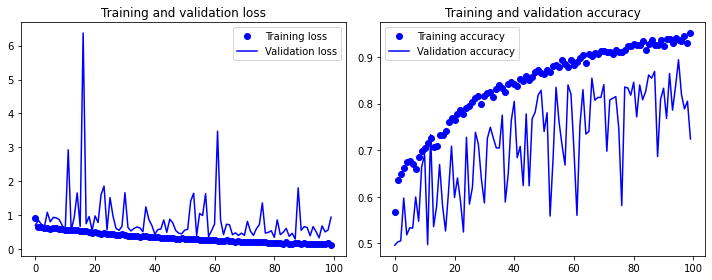

In [66]:
resnet50.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=32,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블을 만들어야 합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = resnet50.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2
)

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.tight_layout()
plt.show()

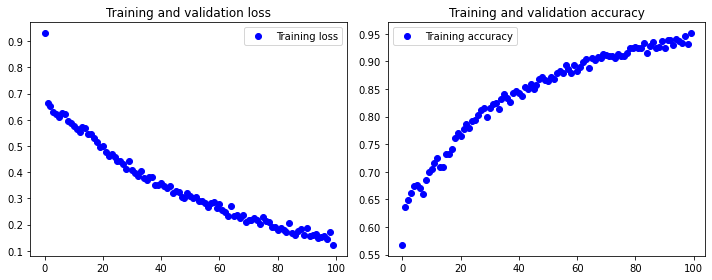

In [71]:

loss = history.history['loss']
#val_loss = history.history['val_loss']

acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.figure(figsize=(10, 4))

plt.subplot(121)

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.tight_layout()
plt.show()